## Importing required packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tqdm.notebook import tqdm
import glob
import imgaug.augmenters as iaa
import wandb
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Looking at a sample image from the data

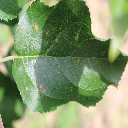

In [2]:
load_img('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg',target_size=(128,128))

In [3]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

In [4]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

## Creating X and y array to feed to the model 

In [5]:
X = []
y = []
for image in tqdm(glob.glob('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_*')):
    img = np.array(load_img(image,target_size = (224,224)))
    X.append(img)
    id = image.split('/')[-1].split(".")[0]
    y.append(train.loc[train['image_id'] == id,['healthy',"multiple_diseases",'rust','scab']])

  0%|          | 0/1821 [00:00<?, ?it/s]

In [6]:
X = np.array(X)
y = np.array(y).reshape(1821,4)

In [7]:
classes = list(train.columns[1:])
classes

['healthy', 'multiple_diseases', 'rust', 'scab']

## Check if the array X and y are created correctly

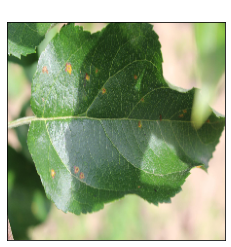

In [8]:
plt.imshow(X[0])
plt.title(classes[np.argmax(y[0])],color='white')
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
plt.show()

In [9]:
train.loc[train.image_id == 'Train_1524']


image_id  healthy  multiple_diseases  rust  scab
1524  Train_1524        0                  0     1     0

## Splitting the data into 80% train and 20% test

In [11]:
cut = round(X.shape[0]*0.8)
cut

1457

In [12]:
X_train = X[:cut]
X_test = X[cut:]
y_train = y[:cut]
y_test = y[cut:]

## Creating a basic model to check the performance on the already provided dataset

This model does not have regularzation and does not takes any augmeted data as well.

In [13]:
# initializing the model
model = tf.keras.models.Sequential()

# adding layers to the model
model.add(tf.keras.layers.Conv2D(input_shape = (224,224,3),activation='relu',kernel_size = (3,3),filters = 16))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# flattening the extracted features
model.add(tf.keras.layers.Flatten())

# fully connected NN
model.add(tf.keras.layers.Dense(300,activation='relu'))
model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = 'accuracy', loss = 'categorical_crossentropy')

In [15]:
model.fit(X_train, y_train, epochs = 15, validation_data = (X_test,y_test))
history = model.history.history

Epoch 1/15
46/46 [==============================] - 11s 38ms/step - loss: 56.9605 - accuracy: 0.3507 - val_loss: 11.9809 - val_accuracy: 0.4258
Epoch 2/15
46/46 [==============================] - 1s 28ms/step - loss: 7.1428 - accuracy: 0.5148 - val_loss: 5.1420 - val_accuracy: 0.3626
Epoch 3/15
46/46 [==============================] - 1s 27ms/step - loss: 2.4118 - accuracy: 0.6699 - val_loss: 4.8363 - val_accuracy: 0.4368
Epoch 4/15
46/46 [==============================] - 1s 28ms/step - loss: 0.9412 - accuracy: 0.8174 - val_loss: 3.5712 - val_accuracy: 0.4698
Epoch 5/15
46/46 [==============================] - 1s 27ms/step - loss: 0.6094 - accuracy: 0.8634 - val_loss: 4.6137 - val_accuracy: 0.4863
Epoch 6/15
46/46 [==============================] - 1s 26ms/step - loss: 0.2388 - accuracy: 0.9389 - val_loss: 3.7403 - val_accuracy: 0.5082
Epoch 7/15
46/46 [==============================] - 1s 28ms/step - loss: 0.0969 - accuracy: 0.9698 - val_loss: 3.5772 - val_accuracy: 0.5055
Epoch 8/15

In [16]:
def plot(hist):
    fig = plt.subplots(1,2,figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(hist["loss"])
    plt.plot(hist['val_loss'])
    plt.legend(['Training','Validation'])
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(hist["accuracy"])
    plt.plot(hist['val_accuracy'])
    plt.legend(['Training','Validation'])
    plt.title('Accuracy')
    #plt.savefig(f'/kaggle/working/{filename}.png')
    plt.show()

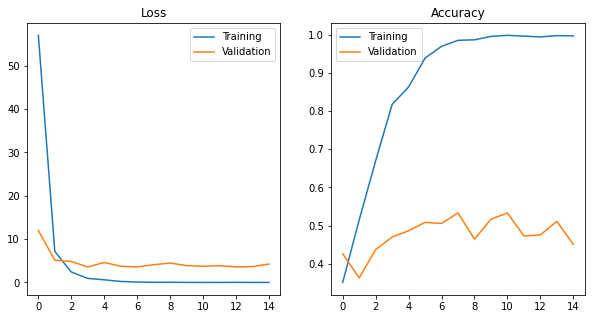

In [17]:
plot(model.history.history)

The basic model is surely unable to generalize, as seen in EDA the data available is not sufficeint so we will have to use the data augmentation, which will create variations of data that can be passed to the model at the time of training which can make our model more robust, for this we will use python package **imgaug**.

## Data Augmentation

Suppose we have 5 images of leaves through augmentation this can be increased to large number of images of leaves as in example below from 5 images we created additional 5 images of leaves by flipping them left to right and vice versa

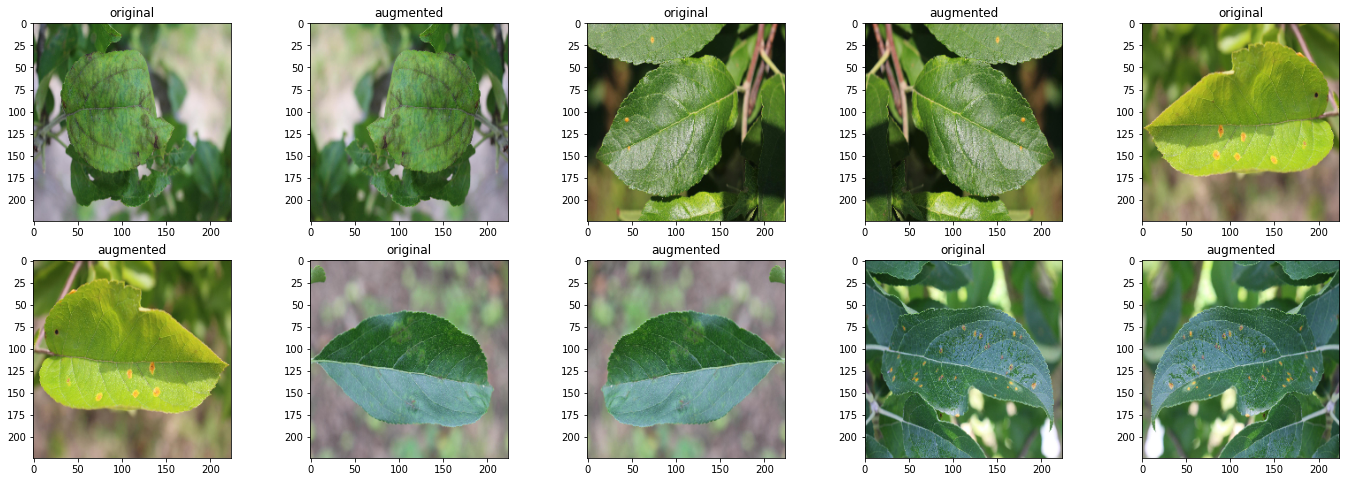

In [18]:
aug = iaa.Sequential([
    iaa.Fliplr()
])

plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

In a similar way we can flip the images up and down to create more images from the finite number of images

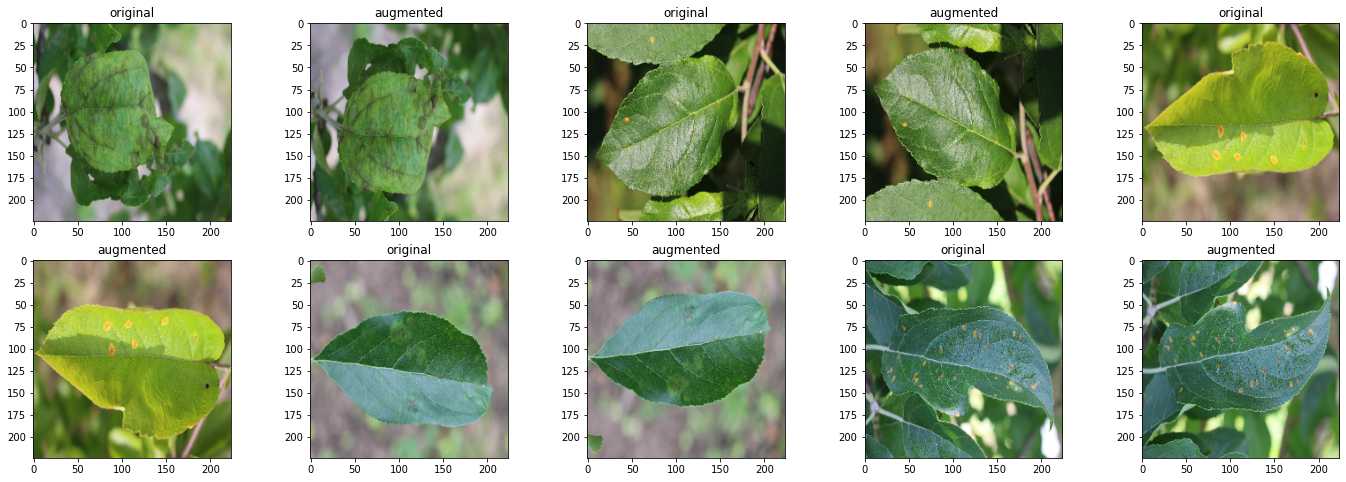

In [19]:
aug = iaa.Sequential([
    iaa.Flipud()
])

plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

Using the Affine method we can crop the images , zoom in and out and also rotate the images which helps in distributing the features in different location on the frame thus making the model to capture the fetures more robustly.

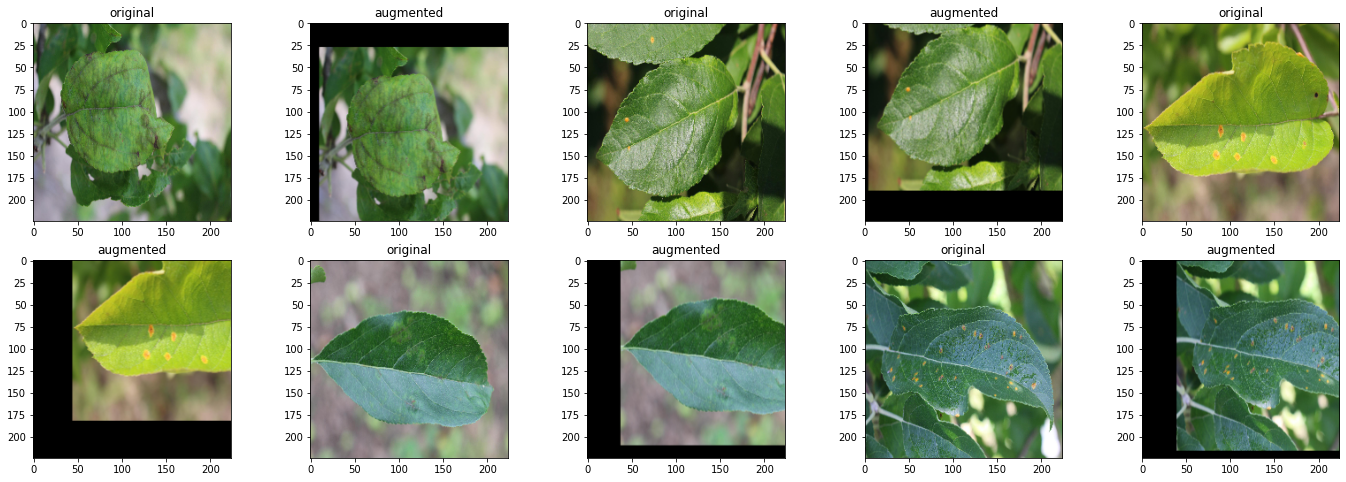

In [20]:
aug = iaa.Sequential([
    iaa.Affine (translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
])

    
plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

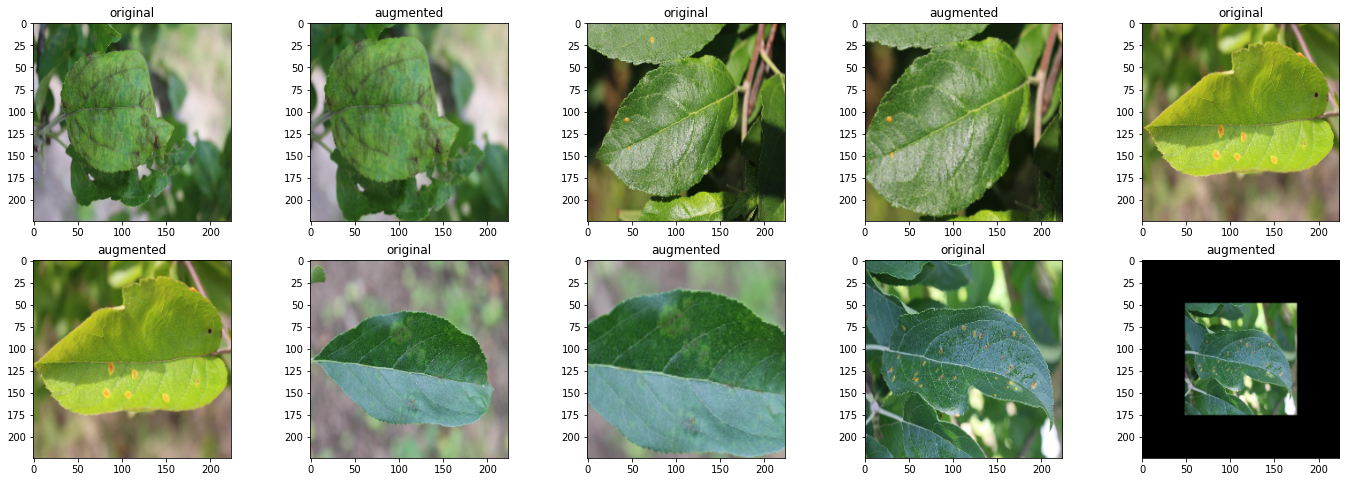

In [21]:
aug = iaa.Sequential([
    iaa.Affine (scale=(0.5, 1.5))
])

    
plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

Using the multiply function of imgaug function we can increase and decrease the brightness of images.

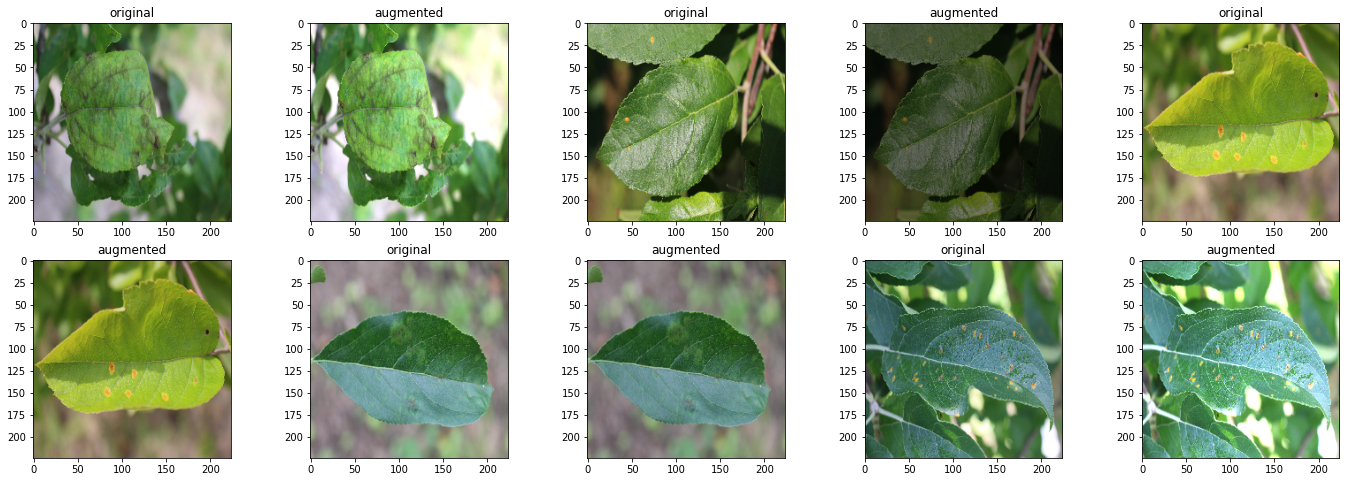

In [22]:
aug = iaa.Sequential([
    iaa.Multiply((0.5,1.5))
])

    
plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

Using the linear contrast function we can increase/decrease the contrast in the images.

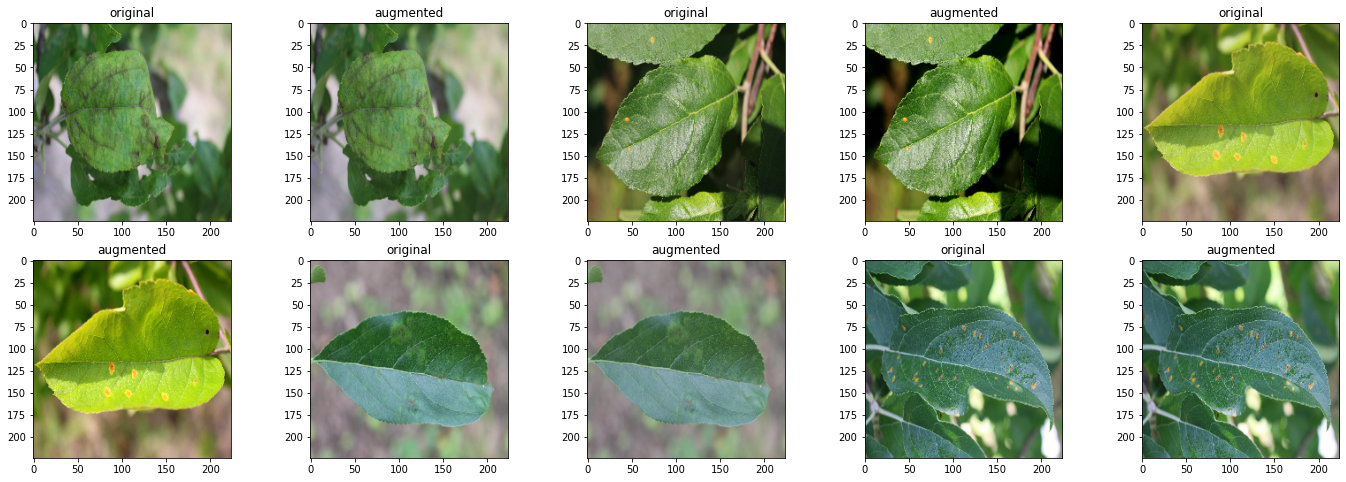

In [23]:
aug = iaa.Sequential([
    iaa.LinearContrast((0.7, 1.7)),
])

    
plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

Gaussian Blur applies blur to the images

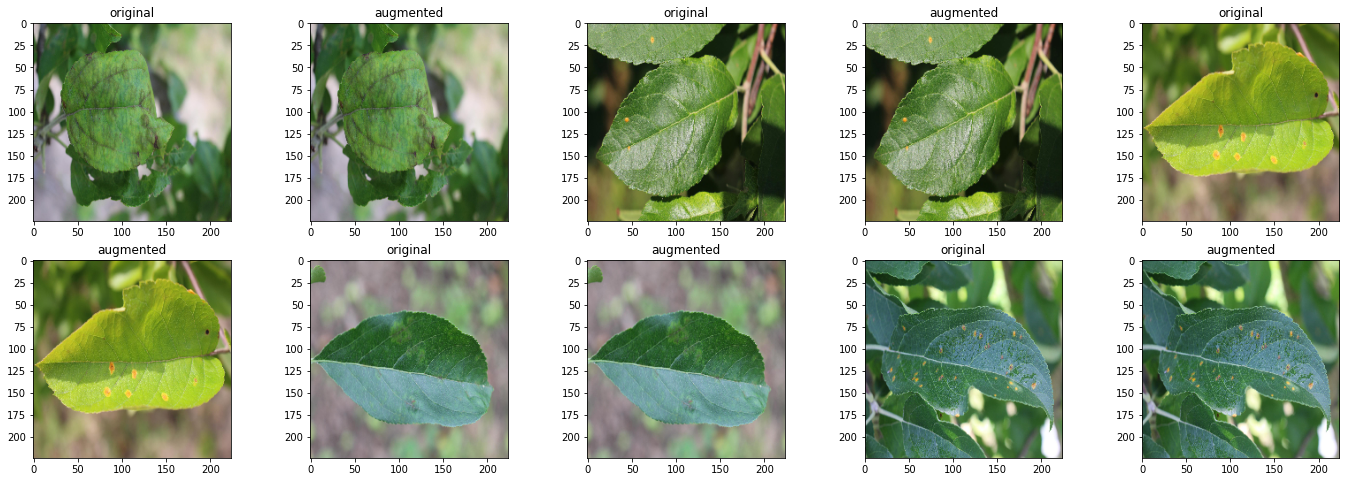

In [24]:
aug = iaa.Sequential([
        iaa.GaussianBlur ((0.3))
])

    
plt.subplots(2,5,figsize=(24,8))
orig,augm = 1,2
for i in range(1,6):
    plt.subplot(2,5,orig)
    plt.title("original")
    plt.imshow(X_train[i])
    orig += 2
    
    plt.subplot(2,5,augm)
    plt.title("augmented")
    plt.imshow(aug(image = X_train[i]))
    augm += 2

As seen above from 5 images we have created total of 35 additional images with variations, which can be feed to the model so that it learns the fetures robustly, The data set doesnot have enough images for the scab diseases using the data augmentation techniques additional images will be created from the existing images tus enabling the model to learn the fetures of scab disease more accurately and it will be able to distinguish between all the different classes.

Below we create a function that applies data augmentation to the whole dataset combining all the above mentioned methods, we will call this function at the time of model fitting and pass X_train dataset to this function.

On every epcoh the function will generate a dataset of images which will be different from the orignal images and very time they will be different enabling th model to learn on a large dataset.

In [25]:
def augment():
    augmentation = iaa.Sequential([
        # 1. Flip
        iaa.Fliplr (0.5),
        iaa.Flipud(0.5),
        iaa.Affine (translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-20, 20),
        scale=(0.5, 1.5)),
        iaa.Multiply((0.8,1.2)),
        iaa.LinearContrast((0.6, 1.4)),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur ((0.3)))
        
    ])
    augmented_images = augmentation(images=X_train.astype(np.uint8))
    return augmented_images

In [26]:
#Tensor Board configuration
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
ngrokkey = user_secrets.get_secret("ngrok")

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing

!./ngrok authtoken $ngrokkey

pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./logs/ --port 6006 --bind_all &",
                        "./ngrok http 6006 &"
                        ]]

--2023-01-16 20:35:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  41.7MB/s    in 0.3s    

2023-01-16 20:35:11 (41.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [27]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.10.1 at http://3d05c806c806:6006/ (Press CTRL+C to quit)


https://ea67-35-222-202-65.ngrok.io


In [28]:
# Login to w&b api to store the model performance
user_secrets = UserSecretsClient()
wandbkey = user_secrets.get_secret("wandb_api")
wandb.login(key=wandbkey)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Creating Checkpoints for Models

In [29]:
## Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20)


!mkdir -p ./logs/CNN2

# Tensorboard Callback
tbd_callback = tf.keras.callbacks.TensorBoard(log_dir = './logs/CNN2')


# initializing the wandb api

run = wandb.init(project='plant-pathology', 
                 group='CNN2', 
                 job_type='train')

# callback of w&b


wb = wandb.keras.WandbCallback()



epoch = 200

wandb: Currently logged in as: anup-s-0201. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


## MODEL 2

In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape = (224,224,3),activation='relu',kernel_size = (3,3),filters = 16))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(300,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

In [31]:
model.compile(optimizer = tf.keras.optimizers.Adam(), metrics = 'accuracy', loss = 'categorical_crossentropy')

In [32]:
model.fit(augment(), y_train, epochs = epoch, validation_data = (X_test,y_test),callbacks = [wb,es,tbd_callback])

Epoch 1/200
46/46 [==============================] - 4s 69ms/step - loss: 11.5836 - accuracy: 0.3349 - val_loss: 1.3809 - val_accuracy: 0.3846
Epoch 2/200
46/46 [==============================] - 2s 44ms/step - loss: 1.3717 - accuracy: 0.4242 - val_loss: 1.2908 - val_accuracy: 0.3489
Epoch 3/200
46/46 [==============================] - 2s 37ms/step - loss: 1.1187 - accuracy: 0.4612 - val_loss: 1.3790 - val_accuracy: 0.3407
Epoch 4/200
46/46 [==============================] - 2s 37ms/step - loss: 1.0538 - accuracy: 0.4955 - val_loss: 1.6807 - val_accuracy: 0.3654
Epoch 5/200
46/46 [==============================] - 2s 37ms/step - loss: 0.9905 - accuracy: 0.5504 - val_loss: 2.0438 - val_accuracy: 0.3489
Epoch 6/200
46/46 [==============================] - 2s 37ms/step - loss: 0.9539 - accuracy: 0.5903 - val_loss: 5.7747 - val_accuracy: 0.3654
Epoch 7/200
46/46 [==============================] - 2s 37ms/step - loss: 0.8708 - accuracy: 0.6102 - val_loss: 3.8289 - val_accuracy: 0.3324
Epoch

In [33]:
run.finish()

## Model 3

In [34]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape = (224,224,3),kernel_size = (3,3),filters = 16))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(300,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

In [35]:
model.compile(optimizer = tf.keras.optimizers.Adam(), metrics = 'accuracy', loss = 'categorical_crossentropy')

In [36]:
## Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20)

!mkdir -p ./logs/CNN3

# Tensorboard Callback
tbd_callback = tf.keras.callbacks.TensorBoard(log_dir = './logs/CNN3')


# initializing the wandb api

run = wandb.init(project='plant-pathology', 
                 group='CNN3', 
                 job_type='train')

# callback of w&b


wb = wandb.keras.WandbCallback()

In [37]:
model.fit(augment(), y_train, epochs = epoch, validation_data = (X_test,y_test),callbacks = [wb,es,tbd_callback])

Epoch 1/200
46/46 [==============================] - 11s 189ms/step - loss: 68.3120 - accuracy: 0.3116 - val_loss: 74.8491 - val_accuracy: 0.3571
Epoch 2/200
46/46 [==============================] - 6s 122ms/step - loss: 1.8995 - accuracy: 0.3404 - val_loss: 1.4383 - val_accuracy: 0.3599
Epoch 3/200
46/46 [==============================] - 6s 127ms/step - loss: 1.3487 - accuracy: 0.3603 - val_loss: 1.3610 - val_accuracy: 0.3571
Epoch 4/200
46/46 [==============================] - 6s 128ms/step - loss: 1.3515 - accuracy: 0.3445 - val_loss: 1.3693 - val_accuracy: 0.3434
Epoch 5/200
46/46 [==============================] - 6s 125ms/step - loss: 1.3445 - accuracy: 0.3384 - val_loss: 1.3420 - val_accuracy: 0.3599
Epoch 6/200
46/46 [==============================] - 5s 115ms/step - loss: 1.3314 - accuracy: 0.3466 - val_loss: 1.3282 - val_accuracy: 0.3654
Epoch 7/200
46/46 [==============================] - 6s 121ms/step - loss: 1.3199 - accuracy: 0.3521 - val_loss: 1.3148 - val_accuracy: 0.3

In [38]:
run.finish()

## Model 4

In [39]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape = (224,224,3),activation='relu',kernel_size = (3,3),filters = 16))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(200,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

In [40]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = 'accuracy', loss = 'categorical_crossentropy')

In [41]:
## Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20)


!mkdir -p ./logs/CNN4

# Tensorboard Callback
tbd_callback = tf.keras.callbacks.TensorBoard(log_dir = './logs/CNN4')


# initializing the wandb api

run = wandb.init(project='plant-pathology', 
                 group='CNN4', 
                 job_type='train')

# callback of w&b


wb = wandb.keras.WandbCallback()

In [42]:
model.fit(augment(), y_train, epochs = epoch, validation_data = (X_test,y_test),callbacks = [wb,es,tbd_callback])

Epoch 1/200
46/46 [==============================] - 8s 126ms/step - loss: 29.0000 - accuracy: 0.2752 - val_loss: 1.3740 - val_accuracy: 0.3352
Epoch 2/200
46/46 [==============================] - 3s 75ms/step - loss: 1.3656 - accuracy: 0.3624 - val_loss: 1.3803 - val_accuracy: 0.3132
Epoch 3/200
46/46 [==============================] - 3s 76ms/step - loss: 1.3252 - accuracy: 0.3500 - val_loss: 1.3013 - val_accuracy: 0.3462
Epoch 4/200
46/46 [==============================] - 3s 75ms/step - loss: 1.2990 - accuracy: 0.3535 - val_loss: 1.3221 - val_accuracy: 0.3407
Epoch 5/200
46/46 [==============================] - 4s 78ms/step - loss: 1.2504 - accuracy: 0.3699 - val_loss: 1.2926 - val_accuracy: 0.3819
Epoch 6/200
46/46 [==============================] - 4s 77ms/step - loss: 1.2355 - accuracy: 0.3775 - val_loss: 1.3307 - val_accuracy: 0.3791
Epoch 7/200
46/46 [==============================] - 3s 76ms/step - loss: 1.1742 - accuracy: 0.4207 - val_loss: 1.2900 - val_accuracy: 0.4011
Epoc

In [43]:
run.finish()

## Model 5

In [44]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape = (224,224,3),activation='relu',kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(500,use_bias=False))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(50,use_bias=False))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

In [45]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = 'accuracy', loss = 'categorical_crossentropy')

In [46]:
## Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20)


!mkdir -p ./logs/CNN5

# Tensorboard Callback
tbd_callback = tf.keras.callbacks.TensorBoard(log_dir = './logs/CNN5')


# initializing the wandb api

run = wandb.init(project='plant-pathology', 
                 group='CNN5', 
                 job_type='train')

# callback of w&b


wb = wandb.keras.WandbCallback()

In [47]:
model.fit(augment(), y_train, epochs = epoch, validation_data = (X_test,y_test),callbacks=[es,tbd_callback,wb])

Epoch 1/200
46/46 [==============================] - 30s 473ms/step - loss: 2.6179 - accuracy: 0.3006 - val_loss: 1.6631 - val_accuracy: 0.2308
Epoch 2/200
46/46 [==============================] - 14s 311ms/step - loss: 1.7312 - accuracy: 0.3123 - val_loss: 2.4517 - val_accuracy: 0.0879
Epoch 3/200
46/46 [==============================] - 14s 315ms/step - loss: 1.5869 - accuracy: 0.3116 - val_loss: 2.1576 - val_accuracy: 0.1593
Epoch 4/200
46/46 [==============================] - 14s 303ms/step - loss: 1.5459 - accuracy: 0.3185 - val_loss: 1.8563 - val_accuracy: 0.2802
Epoch 5/200
46/46 [==============================] - 14s 303ms/step - loss: 1.5226 - accuracy: 0.3171 - val_loss: 1.7968 - val_accuracy: 0.2445
Epoch 6/200
46/46 [==============================] - 14s 306ms/step - loss: 1.5939 - accuracy: 0.3288 - val_loss: 1.5244 - val_accuracy: 0.3159
Epoch 7/200
46/46 [==============================] - 15s 318ms/step - loss: 1.4881 - accuracy: 0.3404 - val_loss: 1.4742 - val_accuracy:

In [48]:
run.finish()

## GPU CONFIG

In [49]:
GPUS = ["GPU:0","GPU:1"]
strategy = tf.distribute.MirroredStrategy( GPUS )
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

Number of devices: 2


In [50]:
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(input_shape = (224,224,3),activation='relu',kernel_size = (3,3),filters = 32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(activation='relu',kernel_size = (3,3),filters = 128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(500,use_bias=False))
    model.add(tf.keras.layers.BatchNormalization(scale=False))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(50,use_bias=False))
    model.add(tf.keras.layers.BatchNormalization(scale=False))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 128)     36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      3

In [52]:
with strategy.scope():
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0003), metrics = 'accuracy', loss = 'categorical_crossentropy')

In [53]:
## Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20)


!mkdir -p ./logs/CNN7

# Tensorboard Callback
tbd_callback = tf.keras.callbacks.TensorBoard(log_dir = './logs/CNN7')


# initializing the wandb api

run = wandb.init(project='plant-pathology', 
                 group='CNN7', 
                 job_type='train')

# callback of w&b


wb = wandb.keras.WandbCallback()


#SAVING THE BEST MODEL

filepath = '/kaggle/working/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

chkpnt = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'auto',
)

In [54]:
model.fit(augment(),y_train, epochs = epoch, validation_data = (X_test,y_test),batch_size=160,callbacks = [chkpnt,es,wb,tbd_callback])

Epoch 1/200
10/10 [==============================] - 60s 3s/step - loss: 1.7256 - accuracy: 0.2745 - val_loss: 1.3722 - val_accuracy: 0.3338
Epoch 2/200
10/10 [==============================] - 8s 844ms/step - loss: 1.6905 - accuracy: 0.2787 - val_loss: 1.3615 - val_accuracy: 0.3379
Epoch 3/200
10/10 [==============================] - 8s 834ms/step - loss: 1.6719 - accuracy: 0.2588 - val_loss: 1.3481 - val_accuracy: 0.3379
Epoch 4/200
10/10 [==============================] - 8s 835ms/step - loss: 1.6598 - accuracy: 0.2697 - val_loss: 1.3386 - val_accuracy: 0.3379
Epoch 5/200
10/10 [==============================] - 9s 873ms/step - loss: 1.5956 - accuracy: 0.2965 - val_loss: 1.3324 - val_accuracy: 0.3379
Epoch 6/200
10/10 [==============================] - 9s 868ms/step - loss: 1.5955 - accuracy: 0.2910 - val_loss: 1.3291 - val_accuracy: 0.3379
Epoch 7/200
10/10 [==============================] - 9s 873ms/step - loss: 1.5936 - accuracy: 0.2759 - val_loss: 1.3291 - val_accuracy: 0.3379
E

IndexError: pop from empty list

In [55]:
run.finish()

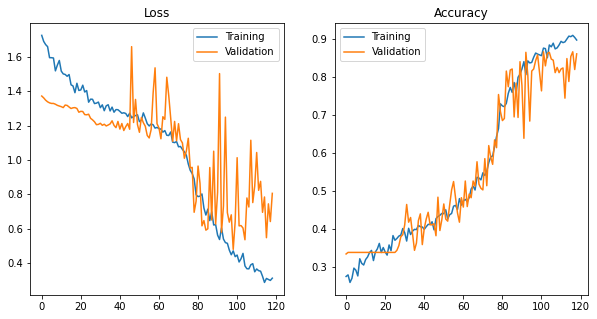

In [56]:
plot(model.history.history)

### Saving the model and Importing it to work on in different notebook as the ram for this runtime was exceeded on kaggle.